# Mean Error Analysis

In [284]:
EXPORT_LATEX = True

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle  # for custom legend items
from matplotlib.pyplot import *
from matplotlib2tikz import save as _tikz_save

def float_fmt(f: float):
    if f%1==0:
        f = Decimal(f)
        fmt = "{:.0f}"
    elif abs(f)>10000:
        fmt = "{:1.2E}"
    elif abs(f)<0.01:
        fmt = "{:1.2e}"
    elif abs(f)<4:
        fmt = "{:.2f}"
    else:
        fmt = "{:.2f}"
    return fmt.format(f)

pd.set_option('display.precision', 2,
              'display.width', 300,
              'display.chop_threshold', 0.0001,
              'display.expand_frame_repr', False,
              'display.max_rows', 20,
              'max_colwidth', 20,
              'display.float_format', float_fmt)


    
# DATA EXPORT PATHS
# ...data
PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
NAME_DATA_FILES = '*results.txt'
# ...LaTeX
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

lms_red = (204/255, 53/255, 56/255)

EVALUATIONS = ['base', 'em-iterations', 'min-distance', 'reflect-order', 'T60', 'noise', 'wd', 'var-fixed']
PARAMETERS = {'s':None, 'md':0.5, 'wd':1.2, 'T60':0.0, 'SNR':0, 'em':None, 'reflect-order':3, 'var-fixed':0, 'var-val':0.1}

DICT_SUMMARY = {'x1':'count',  # sample size
                'em':np.mean,  # em-iterations
                'T60':np.mean,
                'SNR':np.mean,
                'md':np.mean,
                'reflect-order':np.mean,
                'var-fixed':np.mean,
                'var-val':np.mean,
                'err-mean':np.mean,
                'percent-matched':np.mean}

colors = [lms_red, 'k', 'darkgray', 'orange', 'lightgray', 'lightblue', "blue", "yellow", "magenta", "green"]

WHISKER_PROPS = {'linestyle': 'solid', 'linewidth': 0.5, 'color': '#777777'}
BP_OFFSETS = [0,0,0,0.15,0.25, 0.35, 0.40]

DEFAULT_LINE_PLOT_ARGS = {'kind':'line',
                          'marker':'o',
                          'markersize':6,
                          'color':colors}

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    defaults = {'show_info':False,
                'figurewidth':'\\figurewidth',
                'figureheight':'\\figureheight',
                'textsize':6.0}
    for key, val in defaults.items():
        if key not in kwargs: kwargs[key] = val
            
    _tikz_save(*args, **kwargs)
    
def is_matched(x):
    ret = []
    for el in x:
        if str.lower(str(el))=="nan":
            ret.append(np.NaN)
        elif abs(el)>=0.1:
            ret.append(0)
        elif el==np.NaN:
            ret.append(np.Nan)
        else:
            ret.append(1)
    return ret

def round_to_two(x):
    ret = []
    for el in x:
        ret.append(round(x, 2))
    return ret

def ticks_restrict_to_integer(axis):
    """Restrict the ticks on the given axis to be at least integer,
    that is no half ticks at 1.5 for example.
    """
    from matplotlib.ticker import MultipleLocator
    major_tick_locs = axis.get_majorticklocs()
    if len(major_tick_locs) < 2 or major_tick_locs[1] - major_tick_locs[0] < 1:
        axis.set_major_locator(MultipleLocator(1))

def init_grid(spgrid: tuple, figsize: tuple):
    plt.subplots(spgrid[0],spgrid[1], figsize=figsize)
    ax = list()
    for i in range(1,spgrid[0]*spgrid[1]+1):
        ax.append(plt.subplot(spgrid[0],spgrid[1],i))
    i=0
    return ax, i
        
def adjust_y_axis(step_size, digits=0, min=None, max=None, ax=None):
    if isinstance(ax, type(None)):
        plt.axes()
    if ax.get_ylim()[1]<1:
        ax.set_ylim([0,1])
    start, end = ax.get_ylim()
    if not min: min=start
    if not max: max=round(end+step_size, digits)
    ax.set_yticks(np.arange(min, max, step_size))

def scatter_plot(df, xaxis='n-sources', yaxis='err-mean'):
    x = df[xaxis].values
    y = df[yaxis].values
    means = df.groupby([xaxis]).mean()[yaxis]
    medians = df.groupby([xaxis]).median()[yaxis]
    plt.scatter(x, y, alpha=0.1, c="gray")
    plt.scatter(means.index.values, means.values, alpha=1.0, c=lms_red, marker="o", linewidth="4", label="mean")
    plt.scatter(medians.index.values, medians.values, alpha=1.0, c="black", marker="_", linewidth="2", label="median")
    # plt.xticks(n-sources_range)
    adjust_y_axis(step_size=0.5, digits=2, min=0)
    plt.grid(True, axis='y')
    plt.xlabel("number of sources")
    plt.ylabel("mean localisation error (m)")
    l = plt.legend()
#     if EXPORT_LATEX:
#         tikz_save(PATH_SCATTER_PLOT)
        
def style_boxplot(boxplots, axes=None, color=lms_red):
    # parse arguments
    if not type(boxplots)==type([]): boxplots=[boxplots]
    if not axes: axes = [boxplots[0][0].ax]
    
    fig = axes[0].get_figure()
    for bp in boxplots:
        for key, val in bp[0].lines.items():
            for item in val:
                item.set_color(color)
                item.set_linewidth(0.5)
                if key=="fliers":
                    item.set_markerfacecolor("lightgray")
                    item.set_markeredgewidth(0)
                    item.set_markeredgecolor(color)
                    item.set_markersize(7)
                if key=="medians":
                    pass
                if key=="whiskers" or key=="caps":
                    item.set_color("gray")
                if key=="means":
                    item.set_marker('x')
                    item.set_markerfacecolor(color)
                    item.set_markeredgecolor(color)
    for ax in axes:
        ax.set_title("")
#             ax.set_xlabel("number of sources")
#             ax.set_ylabel("mean localisation error (m)")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(axis="x")
        ax.set_xticklabels([2,3,4,5,6,7])
        ax.set_ylim([0, 1.75])
        ax.set_yticks(np.arange(0, 1.76, 0.25))
    fig.suptitle('')
        
def load_all_data():
    dfs = []
    for desc in EVALUATIONS:
        dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
    try:
        df = pd.concat(dfs)
    except ValueError:
        df = dfs
    return df

def style_line_plot(xlabel, ylabel, grid, ax=None):
    if isinstance(ax, type(None)):
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(axis=grid)
    else:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(axis=grid)
        
def print_summary(df, verbose=True):
    print("DATA FROM: ", set(df["description"].values))
    summary = df.groupby('n-sources').agg(DICT_SUMMARY).rename(columns={'x1':'n', 'em':'em-iterations'})
    print(summary.transpose())
    for col in [x for x in PARAMETERS.keys() if x != "s"]:  # Print additional notes for these columns
        warn=False
        if df[col].min()!=df[col].max():
            col_values = df.pivot_table("x1", index=[col], columns=["n-sources"], aggfunc="count")
            if col_values.min().min()==col_values.max().max():
                n=col_values.min().min()
            else:
                if (col_values.min(axis=1).values-col_values.max(axis=1)).sum() != 0:
                    warn=True
                n = list(col_values.min(axis=1).values)
            print("NOTE: Data contains range of {col} ({values}, n={n})"
                  .format(col=col, values=[str(x) for x in list(col_values.index.values)], n=n))
            if warn and verbose:
                print("WARN: Unbalanced n_sources for '{}'. There may be a trial running at the moment!".format(col))
                print(col_values)
    print()  # empty line at the end
            
def parse_parameters(fname):
    ret = {'s':None, 'md':0.5, 'wd':1.2, 'T60':0.0, 'SNR':0, 'em':None, 'refl-ord':3, 'var-fixed':0, 'var-val':0.1}
    done=False
    s=0
    while not done:
        i = fname.find("_", s)
        i2 = fname.find("_", i+1)
        s=i2
        if i < 0 or i2 < 0:
            done=True
            break
        else:
            fname_slice = fname[i+1:i2]
            name, value = fname_slice.split("=", 1)
            ret[name]=value
    return ret

def calculate_helpers(df: pd.DataFrame):
    df_helpers = (df.loc[:, "x1":"x7":2]-df.loc[:, "x1est":"x7est":2].values).rename(columns={"x{}".format(i):"x{}matched".format(i) for i in range(8)})
    df_helpers = df_helpers.apply(is_matched, axis=1, raw=False)
    df_helpers["total-matched"] = df_helpers.sum(axis=1)
    df_helpers["percent-matched"] = df_helpers["total-matched"] / df["n-sources"].values
    return df_helpers
        
def matlab2pandas(dirname=EVALUATIONS, filename=NAME_DATA_FILES, save_to=None, summary=True):
    dfs = []
    if type(dirname)!=list:
        dirnames = [dirname, ]
    else: dirnames = dirname

    for dirname in dirnames:
        files = glob.glob(path.join(PATH_ROOT,dirname,filename))
        dfs = []

        # read data
        for f in files:
            # look at filename
            fname = f.split(sep="/")[-1]
            params = parse_parameters(fname)
            n_sources = int(params["s"])
            # prepare DataFrame
            df = pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float)
            df.drop(df.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
            df.columns = get_col_names(n_sources)
            df.index = ["t{}".format(i+1) for i in range(len(df))]
            for key, value in params.items():
                df[key] = np.float(value)
            df["description"] = dirname
            dfs.append(df)
        df = pd.concat(dfs)

        # prep data for analysis
        df.rename(columns={'s':'n-sources', 'refl-ord':'reflect-order'}, inplace=True)
        df['SNR'] = df['SNR'].apply(int)
        df['em'] = df['em'].apply(int)
        df['n-sources'] = df['n-sources'].apply(int)
        df["T60"].apply(round, 2)
        df["err-mean"]      = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].mean(axis=1)
        df["err-total"]     = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].sum(axis=1)
        df_helpers = calculate_helpers(df)
        df = pd.concat([df,df_helpers], axis=1)
        if summary:
            print_summary(df)

        if save_to: 
            df.to_pickle(save_to+".pkl")
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

## All Data 

In [2]:
df = load_all_data()
dft = df

In [3]:
print("SUMMARY:")
summary = dft.groupby('n-sources').agg({'x1':'count', 'err-mean':np.mean, 'percent-matched':np.mean}).rename(columns={'x1':'n'})
print(summary.transpose())

if EXPORT_LATEX:
    summary.transpose().to_latex("".join([PATH_LATEX_TABLES, 'summary-all.tex']), column_format="rrrrrrr", bold_rows=True)

SUMMARY:
n-sources          2    3    4    5    6    7
n               8695 8695 8695 8670 8670 8670
err-mean        0.14 0.24 0.34 0.41 0.47 0.45
percent-matched 0.79 0.72 0.66 0.61 0.56 0.53


In [4]:
print_summary(dft, verbose=False)
# dfp = df.pivot_table("x1", index=["n-sources"], columns=["T60", "em", "reflect-order", "md", "SNR","wd","var-val","var-fixed"], aggfunc='count').transpose()
# print("OVERVIEW OF SAMPLE SIZES PER EVALUATION:")
# print(dfp)
# ax = dfp.plot(**DEFAULT_LINE_PLOT_ARGS, figsize=(17,6))
# style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")
# plt.ylim([0,1])
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(fancybox=True, title=("T60","description"))

DATA FROM:  {'em-iterations', 'min-distance', 'T60', 'wd', 'noise', 'reflect-order', 'base', 'var-fixed'}
n-sources          2    3    4    5    6    7
n               8695 8695 8695 8670 8670 8670
em-iterations   6.95 6.95 6.95 6.94 6.94 6.94
T60             0.34 0.34 0.34 0.34 0.34 0.34
SNR             1.43 1.43 1.43 1.44 1.44 1.44
md              0.48 0.48 0.48 0.48 0.48 0.48
reflect-order   2.27 2.27 2.27 2.26 2.26 2.26
var-fixed       0.15 0.15 0.15 0.15 0.15 0.15
var-val         0.48 0.48 0.48 0.48 0.48 0.48
err-mean        0.14 0.24 0.34 0.41 0.47 0.45
percent-matched 0.79 0.72 0.66 0.61 0.56 0.53
NOTE: Data contains range of md (['0.1', '0.3', '0.5', '1.0'], n=[400, 200, 7970, 100])
NOTE: Data contains range of wd (['1.2', '1.3', '1.5'], n=[7870, 400, 400])
NOTE: Data contains range of T60 (['0.0', '0.3', '0.6', '0.9'], n=[1500, 4850, 1920, 400])
NOTE: Data contains range of SNR (['0.0', '5.0', '10.0', '15.0', '30.0'], n=[7850, 200, 200, 210, 210])
NOTE: Data contains range of 

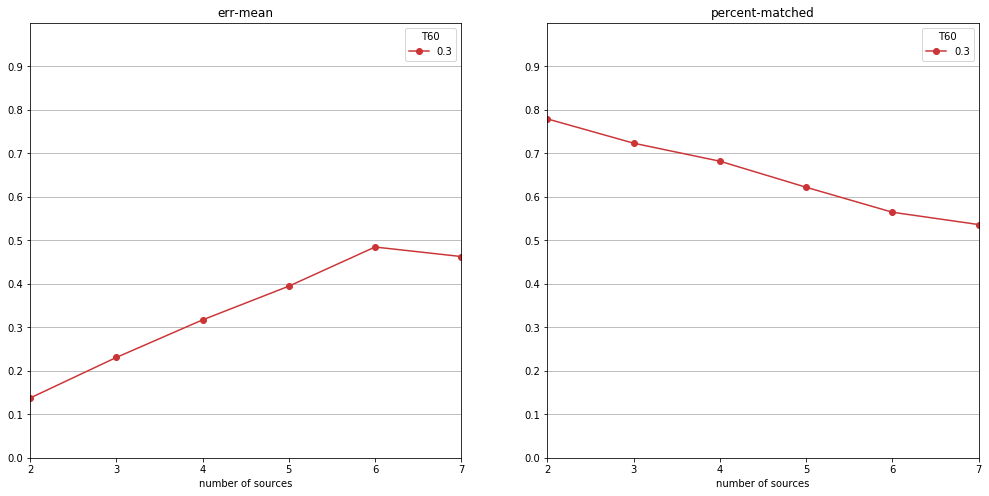

In [17]:
ax, i = init_grid((1,2), (17,8))
cols = ['err-mean', 'percent-matched']
for col in cols:
    dft.pivot_table(col, index=['n-sources'], columns=["T60"], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)

    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(0.1,1,0,1,ax[i])
    i+=1

## Fixed EM-Iterations

In [ ]:
df = load_all_data()

In [77]:
# Manipulate Data
var = "em"
dft = df
dft = dft[dft["description"]=="em-iterations"]
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
# dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)

DATA FROM:  {'em-iterations'}
n-sources          2    3    4    5    6    7
n               1275 1275 1275 1250 1250 1250
em-iterations   7.61 7.61 7.61 7.56 7.56 7.56
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.14 0.23 0.32 0.39 0.48 0.46
percent-matched 0.78 0.72 0.68 0.62 0.56 0.54
NOTE: Data contains range of em (['1.0', '2.0', '3.0', '5.0', '10.0', '20.0'], n=[200, 200, 200, 200, 175, 275])
WARN: Unbalanced n_sources for 'em'. There may be a trial running at the moment!
n-sources    2    3    4    5    6    7
em                                     
1          200  200  200  200  200  200
2          200  200  200  200  200  200
3          200  200  200  200  200  200
5          200  200  200  200  200  200
10         200  200  200  175 

In [78]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
em                                     
1          200  200  200  200  200  200
2          200  200  200  200  200  200
3          200  200  200  200  200  200
5          200  200  200  200  200  200
10         200  200  200  175  175  175
20         275  275  275  275  275  275

MEAN ERROR:
n-sources    2    3    4    5    6    7
em                                     
1         0.19 0.37 0.48 0.50 0.65 0.60
2         0.17 0.23 0.39 0.47 0.52 0.50
3         0.14 0.22 0.29 0.43 0.46 0.44
5         0.12 0.20 0.25 0.36 0.46 0.44
10        0.13 0.20 0.25 0.30 0.38 0.42
20        0.09 0.18 0.27 0.32 0.44 0.40


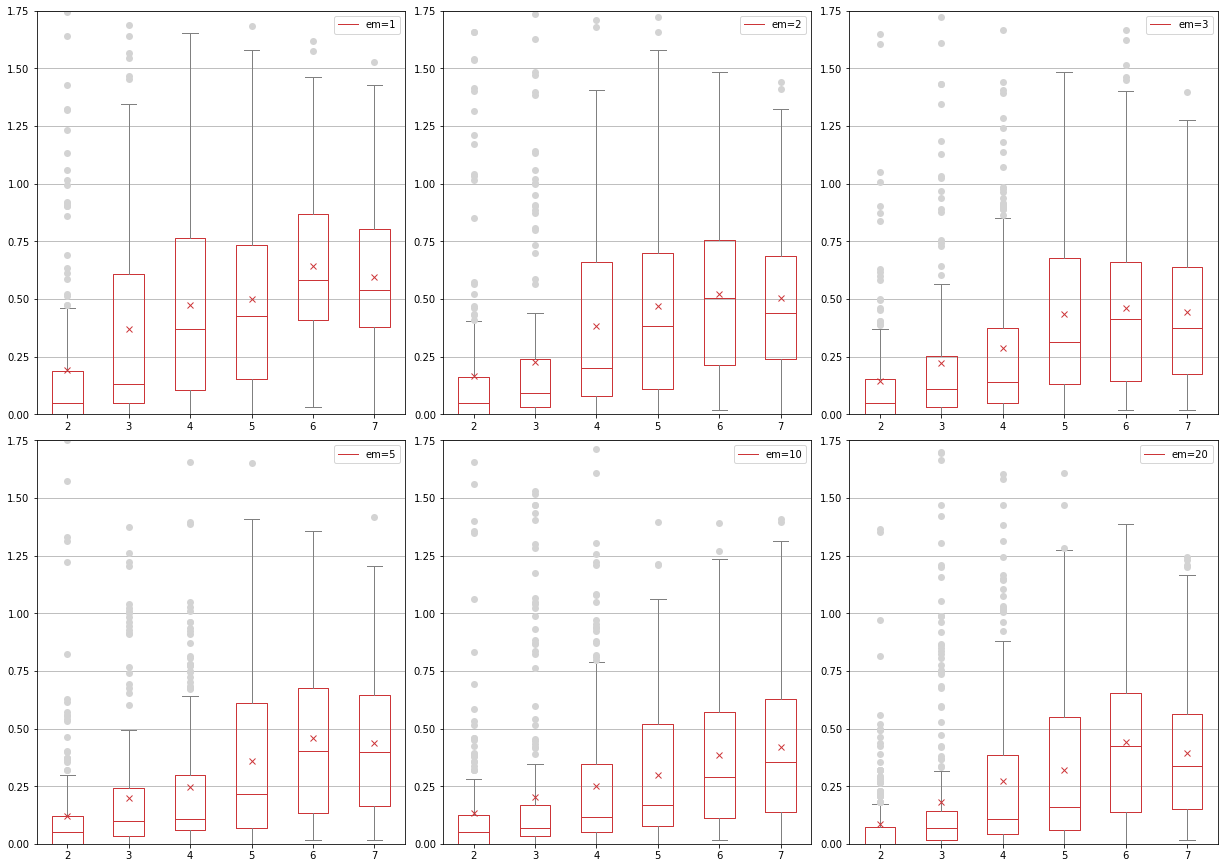

In [199]:
# Print Boxplots
ax, i = init_grid((2,3),(17,12))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=False, ax=ax[i])
        style_boxplot(bp)
#         ax[i].set_xticklabels([2,3,4,5,6,7])
#         ax[i].set_title("{}={}".format(var,val))
        ax[i].legend(["em={}".format(int(val))])
#         ax[i].legend([Rectangle((0, 0), 0, 0, alpha=0.0)], ['em={}'.format(int(val))], handlelength=0)
        i+=1
    except ValueError:
        continue

plt.tight_layout(.5)

# if EXPORT_LATEX:
#         tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-{}-{}.tex'.format(var, int(val))]))


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


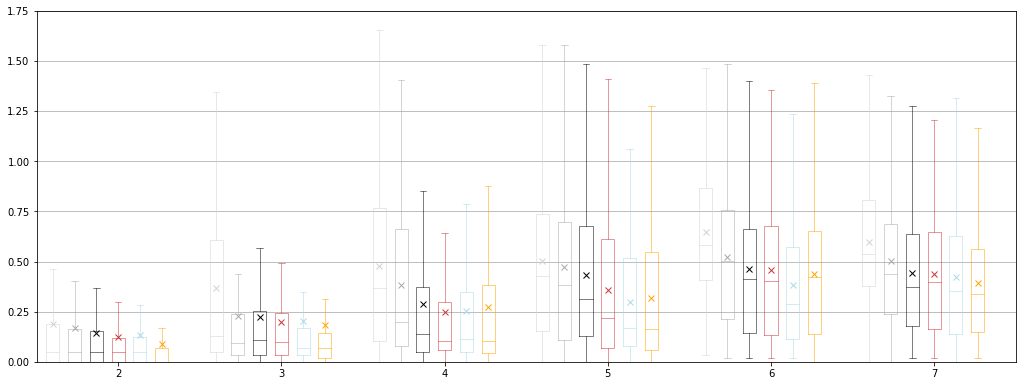

In [210]:
# Joint Boxplot, grouped
offset = 0.40
colors = ['lightgray', 'darkgray', 'k',lms_red, 'lightblue', 'orange']
offset_table = np.arange(-offset, offset, 2*offset/len(colors))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


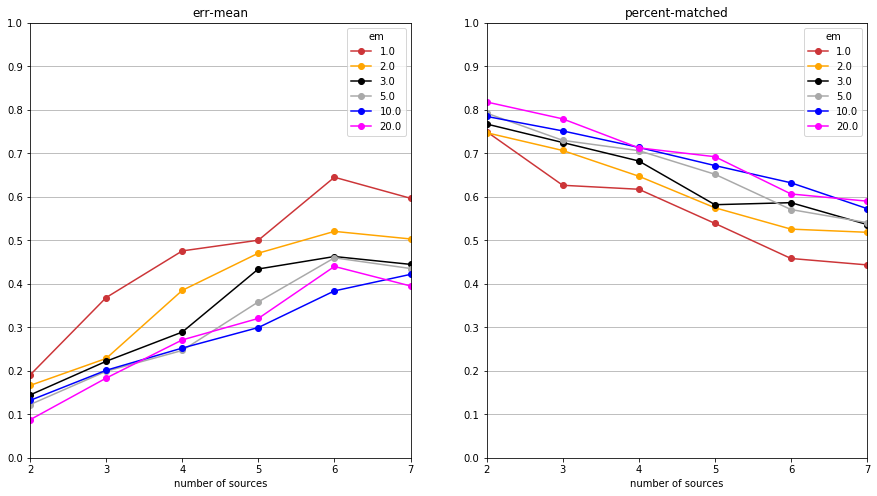

In [52]:
# Print Means in Lineplot
ax, i = init_grid((1,2),(15,8))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'lineplot-{}-{}.tex'.format(var, col)]))

## T60

In [ ]:
df = load_all_data()

In [289]:
# Manipulate Data
var = "T60"
dft = df
dft = dft[dft["reflect-order"]==3]
# dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [290]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
T60                                    
0          300  300  300  300  300  300
0.30       500  500  500  500  500  500
0.60       250  250  250  250  250  250
0.90       200  200  200  200  200  200

MEAN ERROR:
n-sources    2    3    4    5    6    7
T60                                    
0         0.03 0.08 0.13 0.18 0.25 0.30
0.30      0.12 0.18 0.28 0.34 0.39 0.37
0.60      0.15 0.29 0.40 0.51 0.60 0.56
0.90      0.18 0.30 0.49 0.46 0.49 0.48


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


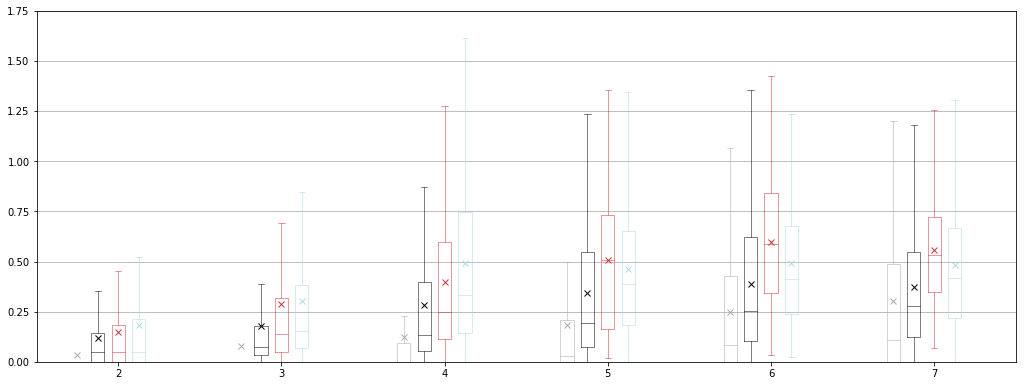

In [291]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.25
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.arange(-offset, offset, 2*offset/len(colors))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

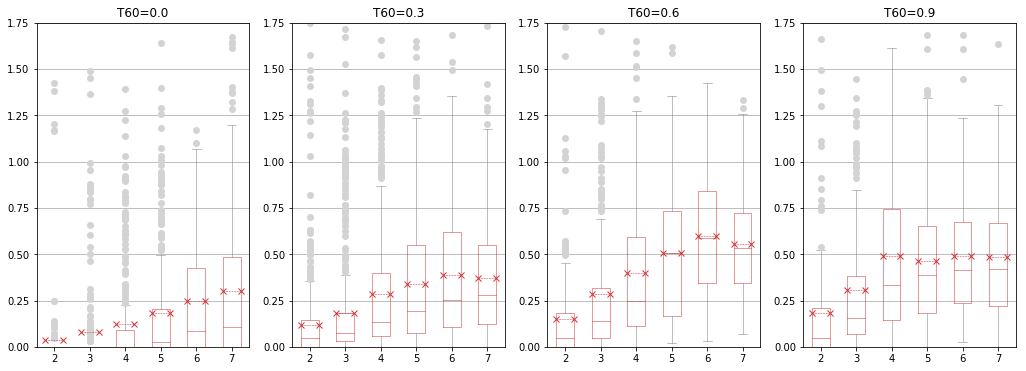

In [213]:
# Print Boxplots
ax, i = init_grid((1,len(dfp.index.values)),(17,6))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

In [ ]:
# Print Means in Lineplot
ax, i = init_grid((1,1),(6,6))
cols = ['err-mean']#, 'percent-matched']
axis_param = [[0.2, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

# Min-Distance 

In [ ]:
df = load_all_data()

In [222]:
var="md"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
# dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [223]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["md"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["md"], aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
md                                     
0.10       100  100  100  100  100  100
0.30       100  100  100  100  100  100
0.50       300  300  300  300  300  300
1          100  100  100  100  100  100

MEAN ERROR:
n-sources        2    3    4    5    6    7
md                                         
0.10          0.02 0.12 0.18 0.18 0.24 0.24
0.30          0.05 0.09 0.15 0.23 0.25 0.20
0.50          0.03 0.08 0.13 0.18 0.25 0.30
1         6.33e-03 0.14 0.37 0.45 0.62 0.72


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


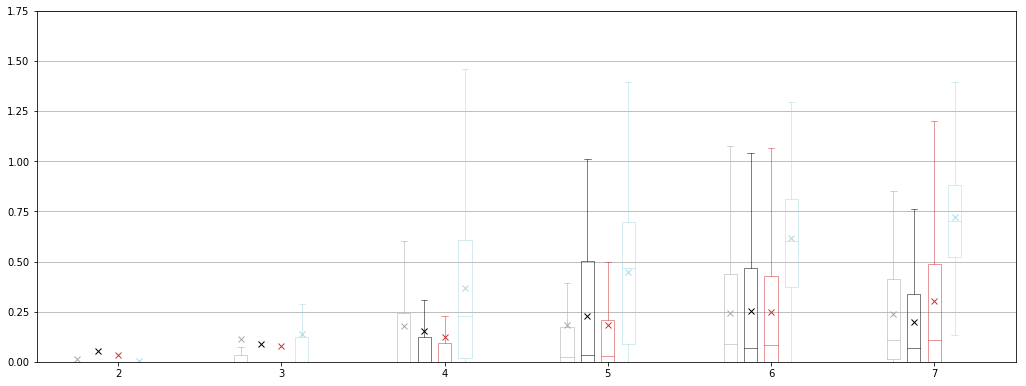

In [224]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.25
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.arange(-offset, offset, 2*offset/len(colors))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
spgrid = (1,4)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,5))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
for md in [.1,.3,.5,1.]:
    dftt = dft[dft["md"]==md]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("min-distance={}".format(md))
        i+=1
    except ValueError:
        continue

In [ ]:
spgrid = (1,2)
plt.subplots(spgrid[0],spgrid[1], figsize=(17,6))
ax = list()
for i in range(1,spgrid[0]*spgrid[1]+1):
    ax.append(plt.subplot(spgrid[0],spgrid[1],i))

i=0
desc = "md"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=desc, aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
    a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

# Reflect Order

In [ ]:
df = load_all_data()

In [286]:
# Manipulate Data
var = "reflect-order"
dft = df
# dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.6]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
# print_summary(dft)

In [287]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["reflect-order"], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=["reflect-order"], aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources        2    3    4    5    6    7
reflect-order                              
-1             250  250  250  250  250  250
1              250  250  250  250  250  250
3              250  250  250  250  250  250

MEAN ERROR:
n-sources        2    3    4    5    6    7
reflect-order                              
-1            0.23 0.50 0.70 0.80 0.83 0.75
1             0.12 0.17 0.25 0.35 0.43 0.43
3             0.15 0.29 0.40 0.51 0.60 0.56


[-0.15  0.    0.15]
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


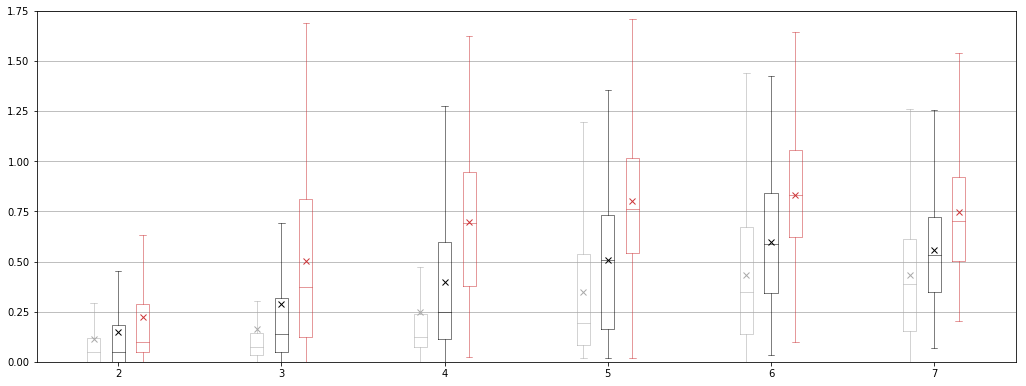

In [288]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
# Joint Boxplot, grouped
offset = 0.15
colors = ['darkgray', 'k',lms_red]
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in [1, 3, -1]:  # custom values to sort -1 as maximum value!
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,3),(17,5))
for val in [1., 3., -1.]:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var, val))
        i+=1
    except ValueError:
        continue

In [ ]:
ax, i = init_grid((1,2),(17,6))
desc = "reflect-order"
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=['reflect-order'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
    adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## SNR

In [ ]:
df = load_all_data()

In [292]:
var = "SNR"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
# dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
dft = dft[dft["description"]=="noise"]
print_summary(dft)

DATA FROM:  {'noise'}
n-sources           2     3     4     5     6     7
n                 900   900   900   900   900   900
em-iterations       5     5     5     5     5     5
T60              0.30  0.30  0.30  0.30  0.30  0.30
SNR             13.33 13.33 13.33 13.33 13.33 13.33
md               0.50  0.50  0.50  0.50  0.50  0.50
reflect-order       3     3     3     3     3     3
var-fixed           0     0     0     0     0     0
var-val          0.10  0.10  0.10  0.10  0.10  0.10
err-mean         0.15  0.28  0.39  0.44  0.45  0.42
percent-matched  0.74  0.65  0.59  0.54  0.49  0.46
NOTE: Data contains range of SNR (['0.0', '5.0', '10.0', '15.0', '30.0'], n=[100, 200, 200, 200, 200])



In [293]:
print("SAMPLE SIZE:")
dfp = dft.pivot_table("x1", index=["n-sources"], columns=[var], aggfunc='count').transpose()
print(dfp)

print("\nMEAN ERROR:")
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
print(dfp)

SAMPLE SIZE:
n-sources    2    3    4    5    6    7
SNR                                    
0          100  100  100  100  100  100
5          200  200  200  200  200  200
10         200  200  200  200  200  200
15         200  200  200  200  200  200
30         200  200  200  200  200  200

MEAN ERROR:
n-sources    2    3    4    5    6    7
SNR                                    
0         0.11 0.20 0.30 0.35 0.34 0.33
5         0.17 0.42 0.56 0.58 0.56 0.52
10        0.17 0.34 0.45 0.45 0.47 0.46
15        0.16 0.25 0.36 0.44 0.46 0.42
30        0.13 0.16 0.24 0.32 0.36 0.32


Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


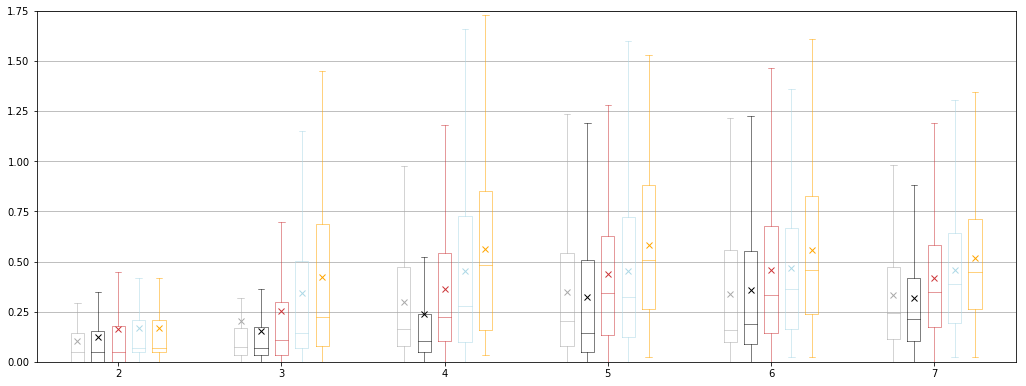

In [296]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()
# Joint Boxplot, grouped
offset = 0.25
colors = ['darkgray', 'k',lms_red, 'lightblue',"orange"]
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}
for val in [0,30,15,10,5]:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,5),(17,4))
for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("{}={}".format(var,val))
        i+=1
    except ValueError:
        continue

In [ ]:
ax, i = init_grid((1,2),(17,6))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.2, 0, 0, 2.01],[0.1, 0, 0,1.01]]
for col in cols:
    a = dft.pivot_table(col, index=['n-sources'], columns=[var], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
#     a.set_ylim([0,1])
    style_line_plot("number of sources", "", grid='x', ax=ax[i])
#     adjust_y_axis(*axis_param[i], a)
    i+=1
    if EXPORT_LATEX:
        tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
        figureheight = '\\figureheight',
        figurewidth = '\\figurewidth'
        )

## Guessing at random

In [256]:
df = load_all_data()
dft = df

DATA FROM:  {'base'}
n-sources          2    3    4    5    6    7
n                300  300  300  300  300  300
em-iterations   6.67 6.67 6.67 6.67 6.67 6.67
T60                0    0    0    0    0    0
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      2    2    2    2    2    2
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.04 0.04 0.12 0.15 0.24 0.26
percent-matched 0.97 0.94 0.90 0.86 0.81 0.79
NOTE: Data contains range of wd (['1.2', '1.3'], n=[250, 50])
NOTE: Data contains range of em (['5.0', '10.0'], n=[200, 100])
NOTE: Data contains range of reflect-order (['0.0', '3.0'], n=[100, 200])



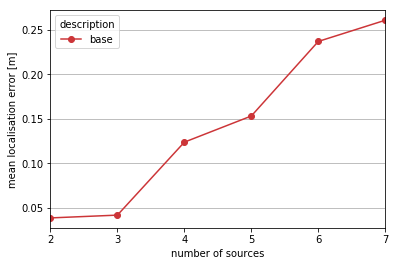

In [261]:
dft = df
dft = dft[dft['description'].isin(['_guessing', 'base'])]
print_summary(dft)
dfp = dft.pivot_table("err-mean", index="description", columns="n-sources", aggfunc='mean').transpose()
dfp.plot(kind='line', marker='o', color=[lms_red, "darkgray", "lightgray", "orange", "black"])

style_line_plot(xlabel="number of sources", ylabel="mean localisation error [m]", grid="y")

# Wall distance

In [265]:
df = load_all_data()
dft = df

In [306]:
var = "wd"
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
# dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources"))

DATA FROM:  {'T60', 'em-iterations', 'noise'}
n-sources          2    3    4    5    6    7
n                900  900  900  900  900  900
em-iterations      5    5    5    5    5    5
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0    0    0    0    0
var-val         0.10 0.10 0.10 0.10 0.10 0.10
err-mean        0.10 0.18 0.25 0.33 0.38 0.37
percent-matched 0.82 0.76 0.71 0.64 0.61 0.56
NOTE: Data contains range of wd (['1.2', '1.3', '1.5'], n=[500, 200, 200])



Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


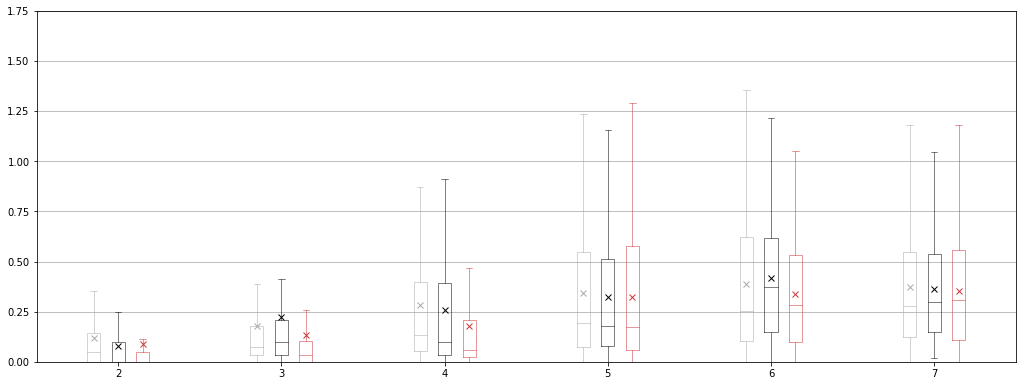

In [307]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.15
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for val in dfp.index.values:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-{}.tex'.format(var)]), strict=True, wrap=False)

In [ ]:
ax, i = init_grid((1,3), (17,8))
for val in [1.2, 1.3, 1.5]:
    dftt = dft[dft[var]==val]
    bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), ax=ax[i],showmeans=True, meanline=True)
    style_boxplot(bp)
    ax[i].set_title("Wall distance = {}m".format(val))
    i+=1

In [ ]:
ax, i = init_grid((2,2),(17,17))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for vf in [1, 0]:
    dftt = dft[dft["var-fixed"]==vf]
    for col in cols:
        a = dftt.pivot_table(col, index=['n-sources'], columns=['var-val', 'var-fixed'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
        a.set_ylim([0,1])
        style_line_plot("number of sources", "", grid='x', ax=ax[i])
        adjust_y_axis(*axis_param[i], a)
        i+=1
        if EXPORT_LATEX:
            tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
            figureheight = '\\figureheight',
            figurewidth = '\\figurewidth'
            )

# Best Case Scenario vs. Worst Case Scenario

In [ ]:
df = load_all_data()

In [309]:
var = "wd"
dfts = []

print("BEST CASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==0]
dft = dft[dft["T60"]==0.0]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.5]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("BASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

print("WORST CASE SCENARIO:")
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==-1]
dft = dft[dft["T60"]==0.9]
dft = dft[dft["em"]==5]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==5]
dft = dft[dft["var-fixed"]==0]
dft = dft[dft["var-val"]==0.1]
print_summary(dft)
dfts.append(dft)

BEST CASE SCENARIO:
DATA FROM:  {'wd'}
n-sources              2    3    4    5    6    7
n                    200  200  200  200  200  200
em-iterations          5    5    5    5    5    5
T60                    0    0    0    0    0    0
SNR                    0    0    0    0    0    0
md                  0.50 0.50 0.50 0.50 0.50 0.50
reflect-order          0    0    0    0    0    0
var-fixed              0    0    0    0    0    0
var-val             0.10 0.10 0.10 0.10 0.10 0.10
err-mean        1.12e-03 0.06 0.11 0.15 0.20 0.25
percent-matched     1.00 0.96 0.93 0.91 0.87 0.83

BASE SCENARIO:
DATA FROM:  {'T60', 'em-iterations', 'noise'}
n-sources          2    3    4    5    6    7
n                500  500  500  500  500  500
em-iterations      5    5    5    5    5    5
T60             0.30 0.30 0.30 0.30 0.30 0.30
SNR                0    0    0    0    0    0
md              0.50 0.50 0.50 0.50 0.50 0.50
reflect-order      3    3    3    3    3    3
var-fixed          0    0  

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


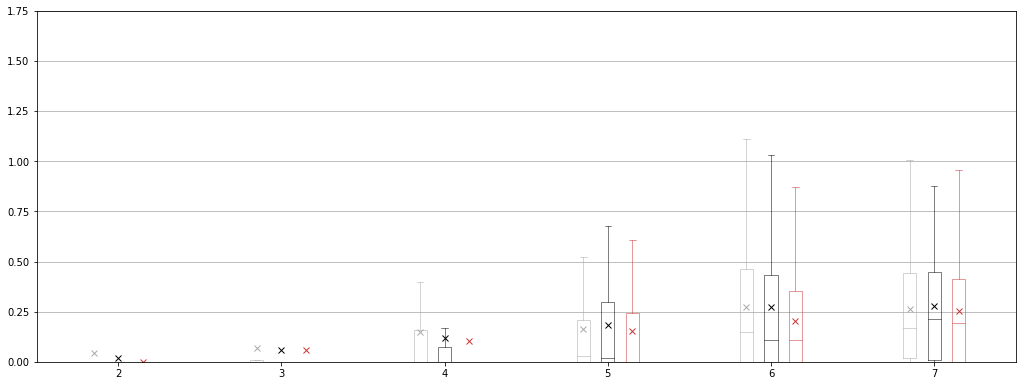

In [305]:
dfp = dft.pivot_table("err-mean", index=["n-sources"], columns=var, aggfunc='mean').transpose()

# Joint Boxplot, grouped
offset = 0.15
colors = ['darkgray', 'k',lms_red, 'lightblue']
offset_table = np.linspace(-offset, offset, len(dfp.index.values))
fig = figure( figsize=(17,6.5) )
ax  = fig.add_subplot(111)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.08,'sym':'','showmeans':True, 'meanline':False}
idx=0
legend_dict = {}

for dft in dfts:
    dftt = dft
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args, whiskerprops = whiskerprops)
    legend_dict["em={}".format(int(val))] = Patch(color=colors[idx])
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=0.5)  # this styles elements not in box
        for el2 in boxlines[el]:
            line = el2
            setp(line, xdata=getp(line, 'xdata')+offset_table[idx])
    idx+=1
# plt.legend(list(legend_dict.values()), list(legend_dict.keys()))  # Legend is added in LaTeX!
if EXPORT_LATEX:
    tikz_save("".join([PATH_LATEX_PLOTS, 'boxplot-joined-best-case.tex'.format(var)]), strict=True, wrap=False)

Axes(0.125,0.125;0.775x0.755)


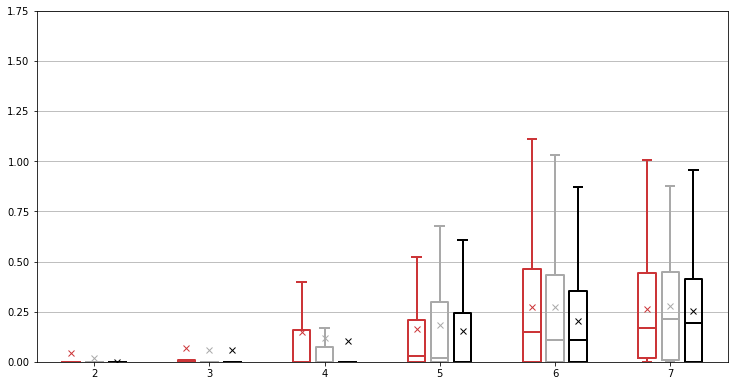

In [303]:
# Joint Boxplot, grouped
offset = 0.20
colors = [lms_red, 'darkgray', 'k']
offset_table = [-offset, 0, offset]
fig = plt.figure(figsize=(12,6.5))
ax  = fig.add_subplot(111)
print(ax)
boxplot_args = {'ax':ax,'notch':False,'return_type':'both','widths':0.15,'sym':'','showmeans':True}
idx=0

for val in [1.2, 1.3, 1.5]:
    dftt = dft[dft["wd"]==val]
    bp = dftt.boxplot("err-mean", by=["n-sources"], **boxplot_args)
    style_boxplot(bp, None, colors[idx])
    boxlines = bp["err-mean"][1]
    for el in boxlines:
        setp(boxlines[el], color=colors[idx],linewidth=2)
        for el2 in boxlines[el]:
            setp(el2, xdata=getp(el2, 'xdata')+offset_table[idx])
    idx+=1

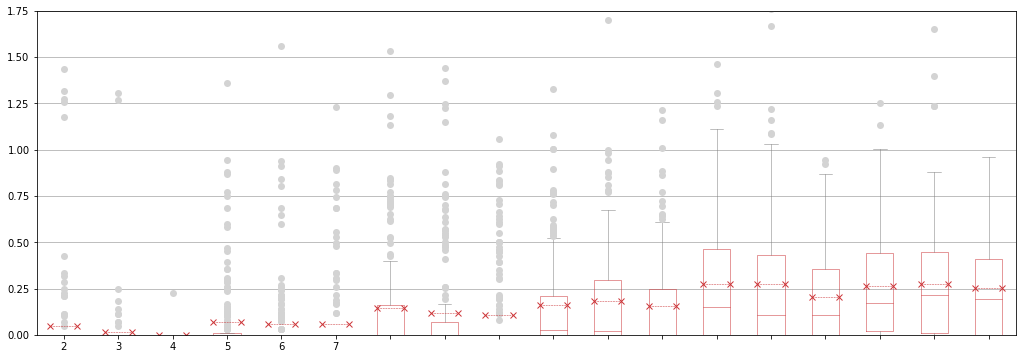

In [300]:
# Joint Boxplot
bp = dft.boxplot("err-mean", by=["n-sources", "wd"], return_type='both', figsize=(17,  6),showmeans=True, meanline=True)
style_boxplot(bp)

In [ ]:
ax, i = init_grid((1,3), (17,8))
for wd in [1.2, 1.3, 1.5]:
    dftt = dft[dft["wd"]==wd]
    bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), ax=ax[i],showmeans=True, meanline=True)
    style_boxplot(bp)
    ax[i].set_title("Wall distance = {}m".format(wd))
    i+=1

# Variance Analysis

In [ ]:
# Load Data
dfs = []
for desc in EVALUATIONS:
    dfs.append(matlab2pandas(dirname=desc, save_to=path.join(PATH_ROOT, desc), summary=False))
try:
    df = pd.concat(dfs)
except ValueError:
    df = dfs

In [ ]:
# Manipulate Data
dft = df
dft = dft[dft["reflect-order"]==3]
dft = dft[dft["T60"]==0.3]
dft = dft[dft["em"]==10]
dft = dft[dft["wd"]==1.2]
dft = dft[dft["md"]==0.5]
dft = dft[dft["SNR"]==0]
# print_summary(dft)

In [ ]:
# Sample Sizes
dfp = dft.pivot_table("x1", index=["n-sources"], columns=["var-val","var-fixed"], aggfunc='count').transpose()
print(dfp)

In [ ]:
# dfp = df.pivot_table("err-mean", index=["description", "wd"], columns="n-sources", aggfunc='mean').transpose()
# dfp.boxplot(column=("n-sources", "var", "var-val"))
ax, i = init_grid((2,6),(17,8))
for vv, vf in [(0.1,1), (0.5,1), (1.0,1), (2.0,1), (3.0,1),(5.0,1), (0.1, 0), (0.5, 0), (1.0, 0), (2.0, 0), (3.0, 0), (5.0, 0)]:
    dftt = dft[dft["var-val"]==vv]
    dftt = dftt[dftt["var-fixed"]==vf]
    try:
        bp = dftt.boxplot('err-mean', by=["n-sources"], return_type='both', figsize=(6,  6), showmeans=True, meanline=True, ax=ax[i])
        style_boxplot(bp)
        ax[i].set_title("var-fixed={}, var-val={}".format(vf, vv))
        i+=1
    except ValueError:
        continue
    

In [ ]:
ax, i = init_grid((2,2),(17,17))
cols = ['err-mean', 'percent-matched']
axis_param = [[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01],[0.1, 0, 0, 1.01],[0.1, 0, 0,1.01]]
for vf in [1, 0]:
    dftt = dft[dft["var-fixed"]==vf]
    for col in cols:
        a = dftt.pivot_table(col, index=['n-sources'], columns=['var-val', 'var-fixed'], aggfunc='mean').plot(**DEFAULT_LINE_PLOT_ARGS, grid=True, ax=ax[i], title=col)
        a.set_ylim([0,1])
        style_line_plot("number of sources", "", grid='x', ax=ax[i])
        adjust_y_axis(*axis_param[i], a)
        i+=1
        if EXPORT_LATEX:
            tikz_save("".join([PATH_LATEX_PLOTS, 'plot_{}_{}.tex'.format(desc, col)]),
            figureheight = '\\figureheight',
            figurewidth = '\\figurewidth'
            )

# Analyse DataFrame

### Examine Outliers

In [ ]:
# print(pd.concat([df[df["err-mean"]>=1.5].loc[:, "err1":"err7"], df[df["err-mean"]>=1.5].loc[:, "x1":"x7"]], axis=1))
print("ERRORS:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "err1":"err7"]))
print("X-COORDINATES:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "x1":"x7est"]))
print("Y-COORDINATES:\n{}\n".format(df[df["err-mean"]>=1.5].loc[:, "y1":"y7est"]))

In [ ]:
# Box Plot
bp = df.boxplot('err-mean', by=["n-sources", "refl-ord"], return_type='both',figsize=(17,  12), showmeans=True, meanline=True)
style_boxplot(bp)

if EXPORT_LATEX:
    tikz_save(PATH_BOX_PLOT, show_info=False)

# Perfect Match Analysis

In [ ]:
dfcp = df.pivot_table("percent-matched", columns="refl-ord", aggfunc='mean').transpose()
dfcp.plot(**DEFAULT_LINE_PLOT_ARGS)
# Style plot
style_line_plot(xlabel="number of sources", ylabel="perfect matches", grid="y")

# Significance Analysis

In [ ]:
from scipy.stats import ttest_ind, describe, norm
from statsmodels.formula.api import ols

means = []
stddevs = []

# extract err-mean per n_sources
cat = {}
for n in set(df["n-sources"].values):
    cat[str(n)] = df[df['n-sources']==n]['err-mean']

x = np.linspace(0,1.5,100)
print("DESCRIPTIVE ANALYSIS:")
fig, ax = plt.subplots(1,3, figsize=(17,  6))
for n, c in cat.items():
    dr = describe(c)
    means.append(dr.mean)
    stddevs.append(np.sqrt(dr.variance))
    y = norm.pdf(x, loc=dr.mean, scale=np.sqrt(dr.variance))
    plt.subplot(131)
    plt.plot(x, y, label=n)  # plot gaussian
    print("{} sources: n={:3}, min={:0.3f}, max={:0.3f}, mean={:0.3f}, variance={:0.3f}, std.dev={:0.3f}".format(
        n, dr.nobs, dr.minmax[0], dr.minmax[1], dr.mean, dr.variance, np.sqrt(dr.variance)))
plt.legend()

plt.subplot(132)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)

plt.subplot(133)
plt.boxplot(list(cat.values()), showmeans=True, meanline=True)
plt.ylim(-0.01, 0.31)
plt.yticks([0, 0.1, 0.2, 0.3])

# This means that given p and t values from a two-tailed test, you would reject the null hypothesis 
# of a greater-than test when p/2 < alpha and t > 0, and of a less-than test when p/2 < alpha and t < 0.    

print("\nT-TEST FOR DIFFERENCE IN MEANS:")
for i1 in set(df["n-sources"].values):
    for i2 in set(df["n-sources"].values):
        if i1!=i2 and i2>i1 and i2<=i1+1:
            ttest = ttest_ind(cat[str(i2)], cat[str(i1)], equal_var=False)
            p_onesided = ttest.pvalue/2
            if p_onesided <= 0.01:sign="***"
            elif p_onesided <= 0.05: sign="**"
            elif p_onesided <= 0.10: sign="*"
            else: sign="(n.s.)"
            print("{}x{}: t={t.statistic:0.3f}, p={p:0.3f} {s:^6}".format(i1, i2, t=ttest, p=p_onesided, s=sign))

print("\nVISUALIZE MEANS AND VARIANCE OF DATA:")

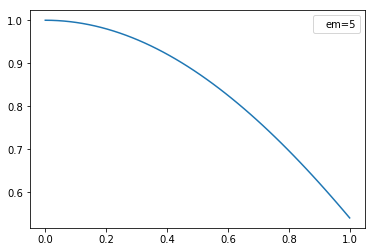

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

x = np.linspace(0, 1)
p1, = plt.plot(x, np.cos(x))

